#**Segment and count all the lemons present in an image given by the user**

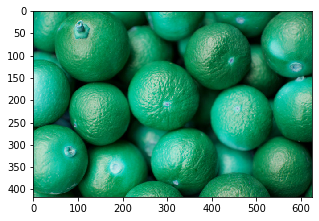

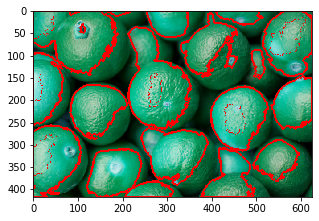

Number of lemon segments detected =  15


In [4]:
#------------------import necessary library
import numpy as np
import cv2
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import time
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
%matplotlib inline

#------------------- Defining function for display images & mask image ----------------------
def show(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, interpolation='nearest')
    plt.show()
def show_mask(mask):
    plt.imshow(mask, cmap='gray')
    plt.show()


#----------------Load Image ------------------------------------
image = cv2.imread('lemon6.jpg')
show(image)


#----------------Convert  image to HSV, then apply Otsu's thresholding and the apply smoothing using medianblur ---------------------

# convert image to hsv scale
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#show(hsv)
h, s, v = cv2.split(hsv)


# Segment using threshold
_, thr = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#show(thr)

# Smoothing image
blur = cv2.medianBlur(thr, 1)
#show(blur)


#------------- Segment the image using morphological operation ------------------------------------

# Noise removal using Morphological opening operation 
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thr,cv2.MORPH_OPEN,kernel, iterations = 2)

# Background area using Dialation 
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding foreground area 
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

#--------------Apply Watershed ------------------------------------------

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]


# Find contour in image
contours, hierarchy = cv2.findContours(blur, 2, 1)

# List to store the contour of area greater then 100
contour_list = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100 :
        contour_list.append(contour)

# Draw contour on image       
img = cv2.drawContours(image, contour_list,  -1, (255,0,0), 3)
show(img)

#--------------------- Count Lemon Segment --------------------
D = ndimage.distance_transform_edt(blur)
localMax = peak_local_max(D, indices=False, min_distance=40, labels=blur)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=blur)

# Taking average 
ws = len(np.unique(labels)) -1
ans = int((ws + len(contour_list)) / 2)
print("Number of lemon segments detected = ", ans)